In [2]:
# Check instance GPUs
!nvidia-smi

Sun Aug 27 21:30:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |      0MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install required libraries
%pip install -q huggingface_hub
%pip install -q -U trl transformers accelerate einops
%pip install -q -U datasets evaluate xformers sentencepiece

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import libraries
import evaluate
from datasets import load_dataset
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline
import pandas as pd
import evaluate
from evaluate.visualization import radar_plot
import torch
import matplotlib

# Load dataset
dataset = load_dataset("financial_phrasebank","sentences_50agree", split='train')
# Select test dataset (20%)
data = dataset.select([i for i in list(range(3873,4841))])

In [5]:
# Create Task for Text Classification
task_evaluator = evaluator("text-classification")

In [6]:
# # Create a custom subclass of TextClassificationEvaluator
# class CustomTextClassificationEvaluator(evaluator(task="text-classification").__class__):
#     METRIC_KWARGS = {"average": "macro"}
    
# # Instantiate the custom evaluator
# task_evaluator = CustomTextClassificationEvaluator()

In [7]:
# Load the desired metrics
accuracy_metric = evaluate.load('accuracy')
# f1_metric = evaluate.load('f1', "multilabel")
# recall_metric = evaluate.load('recall')
# precision_metric = evaluate.load("precision")
# metrics = evaluate.combine([accuracy_metric, f1_metric, precision_metric, recall_metric])
metrics = evaluate.combine([accuracy_metric])

In [8]:
# Result set
results = []

In [9]:
# Model list
models = [
    "distilbert-base-uncased",
    "IngeniousArtist/distilbert-finance",
    "yiyanghkust/finbert-tone",
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "ProsusAI/finbert",
    "stabilityai/stablelm-base-alpha-3b",
    "IngeniousArtist/stablelm-3b-finance",
    "CobraMamba/mamba-gpt-3b-v3",
    "bigscience/bloom-3b",
    "facebook/opt-2.7b",
    "EleutherAI/gpt-neo-2.7B",
    "openlm-research/open_llama_3b_v2",
    "IngeniousArtist/openllama-3b-finance"
]    

i = 0

In [10]:
def return_trainable_parameters(model):
    
    # Prints the number of trainable parameters in the model.
    
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    params = {
        "trainable params": trainable_params, "total params": all_param, "trainable%": (100 * trainable_params / all_param)
    }
    return params

In [11]:
def model_params(model_name):
    
    # Loads model for printing params
    model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    device_map={'': 0},
    trust_remote_code=True,
    use_auth_token=True,
    max_memory=f'{int(torch.cuda.mem_get_info()[0]/1024**3)-2}GB'
    )
    
    # print(return_trainable_parameters(model))
    return return_trainable_parameters(model)

In [12]:
# distilbert-base-uncased

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.5041322314049587, 'total_time_in_seconds': 7.863530796000077, 'samples_per_second': 123.09991848603049, 'latency_in_seconds': 0.008123482227272808, 'trainable params': 66955010, 'total params': 66955010, 'trainable%': 100.0}


In [13]:
# IngeniousArtist/distilbert-finance

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric=metrics,
    label_mapping={"Negative": 0, "Neutral": 1, "Positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'accuracy': 0.7386363636363636, 'total_time_in_seconds': 7.178931293000005, 'samples_per_second': 134.83901161498403, 'latency_in_seconds': 0.0074162513357438065, 'trainable params': 66955779, 'total params': 66955779, 'trainable%': 100.0}


In [14]:
# yiyanghkust/finbert-tone

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric=metrics,
    label_mapping={"Negative": 0, "Neutral": 1, "Positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'accuracy': 0.7758264462809917, 'total_time_in_seconds': 12.497177311000087, 'samples_per_second': 77.45749107264093, 'latency_in_seconds': 0.012910307139462899, 'trainable params': 109754115, 'total params': 109754115, 'trainable%': 100.0}


In [15]:
# cardiffnlp/twitter-roberta-base-sentiment-latest

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric=metrics,
    label_mapping={"negative": 0, "neutral": 1, "positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated

{'accuracy': 0.5919421487603306, 'total_time_in_seconds': 12.629195100999823, 'samples_per_second': 76.64779839558942, 'latency_in_seconds': 0.013046689153925437, 'trainable params': 124647939, 'total params': 124647939, 'trainable%': 100.0}


In [16]:
# ProsusAI/finbert

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric=metrics,
    label_mapping={"negative": 0, "neutral": 1, "positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'accuracy': 0.8853305785123967, 'total_time_in_seconds': 13.28907482999989, 'samples_per_second': 72.84179014589897, 'latency_in_seconds': 0.013728383088842862, 'trainable params': 109484547, 'total params': 109484547, 'trainable%': 100.0}


In [17]:
# stabilityai/stablelm-base-alpha-3b

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric=metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at stabilityai/stablelm-base-alpha-3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at stabilityai/stablelm-base-alpha-3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.4142561983471074, 'total_time_in_seconds': 47.43415295500017, 'samples_per_second': 20.407236973712216, 'latency_in_seconds': 0.04900222412706629, 'trainable params': 3429711872, 'total params': 3429711872, 'trainable%': 100.0}


In [18]:
# IngeniousArtist/stablelm-3b-finance

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"Negative": 0, "Neutral": 1, "Positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'accuracy': 0.08574380165289257, 'total_time_in_seconds': 47.99945602700018, 'samples_per_second': 20.166895213468464, 'latency_in_seconds': 0.049586214903925806, 'trainable params': 3429715968, 'total params': 3429715968, 'trainable%': 100.0}


In [19]:
# CobraMamba/mamba-gpt-3b-v3

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at CobraMamba/mamba-gpt-3b-v3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at CobraMamba/mamba-gpt-3b-v3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.4142561983471074, 'total_time_in_seconds': 45.11266818399963, 'samples_per_second': 21.457387447176668, 'latency_in_seconds': 0.046603996057850865, 'trainable params': 3324080000, 'total params': 3324080000, 'trainable%': 100.0}


In [20]:
# bigscience/bloom-3b

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.503099173553719, 'total_time_in_seconds': 29.393705430999944, 'samples_per_second': 32.93222088900377, 'latency_in_seconds': 0.030365398172520604, 'trainable params': 3002562560, 'total params': 3002562560, 'trainable%': 100.0}


In [21]:
# facebook/opt-2.7b

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-2.7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-2.7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.3646694214876033, 'total_time_in_seconds': 37.710634960000334, 'samples_per_second': 25.669151448305165, 'latency_in_seconds': 0.038957267520661504, 'trainable params': 2651601920, 'total params': 2651601920, 'trainable%': 100.0}


In [22]:
# EleutherAI/gpt-neo-2.7B

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-2.7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-2.7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.41632231404958675, 'total_time_in_seconds': 39.70257359900006, 'samples_per_second': 24.381290990777984, 'latency_in_seconds': 0.04101505537086783, 'trainable params': 2651312640, 'total params': 2651312640, 'trainable%': 100.0}


In [23]:
# openlm-research/open_llama_3b_v2

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some wei

{'accuracy': 0.6157024793388429, 'total_time_in_seconds': 43.43447545700019, 'samples_per_second': 22.28644388622381, 'latency_in_seconds': 0.04487032588533077, 'trainable params': 3324080000, 'total params': 3324080000, 'trainable%': 100.0}


In [24]:
# IngeniousArtist/openllama-3b-finance

eval_results = task_evaluator.compute(
    model_or_pipeline=models[i],
    input_column = "sentence",
    label_column = "label",
    data=data,
    metric= metrics,
    label_mapping={"Negative": 0, "Neutral": 1, "Positive": 2}
)

eval_results.update(model_params(models[i]))
results.append(eval_results)
print(eval_results)
i += 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'accuracy': 0.4142561983471074, 'total_time_in_seconds': 43.44769834899989, 'samples_per_second': 22.279661219897097, 'latency_in_seconds': 0.04488398589772716, 'trainable params': 3324083200, 'total params': 3324083200, 'trainable%': 100.0}


In [53]:
# Create Dataframe

df = pd.DataFrame(results, index=models)
data = df[["accuracy", "total_time_in_seconds", "samples_per_second", "latency_in_seconds", "total params"]]
data

,accuracy,total_time_in_seconds,samples_per_second,latency_in_seconds,total params
distilbert-base-uncased,0.504132,7.863531,123.099918,0.008123,66955010
IngeniousArtist/distilbert-finance,0.738636,7.178931,134.839012,0.007416,66955779
yiyanghkust/finbert-tone,0.775826,12.497177,77.457491,0.012910,109754115
cardiffnlp/twitter-roberta-base-sentiment-latest,0.591942,12.629195,76.647798,0.013047,124647939
ProsusAI/finbert,0.885331,13.289075,72.841790,0.013728,109484547
stabilityai/stablelm-base-alpha-3b,0.414256,47.434153,20.407237,0.049002,3429711872
IngeniousArtist/stablelm-3b-finance,0.085744,47.999456,20.166895,0.049586,3429715968
CobraMamba/mamba-gpt-3b-v3,0.414256,45.112668,21.457387,0.046604,3324080000
bigscience/bloom-3b,0.503099,29.393705,32.932221,0.030365,3002562560
facebook/opt-2.7b,0.364669,37.710635,25.669151,0.038957,2651601920


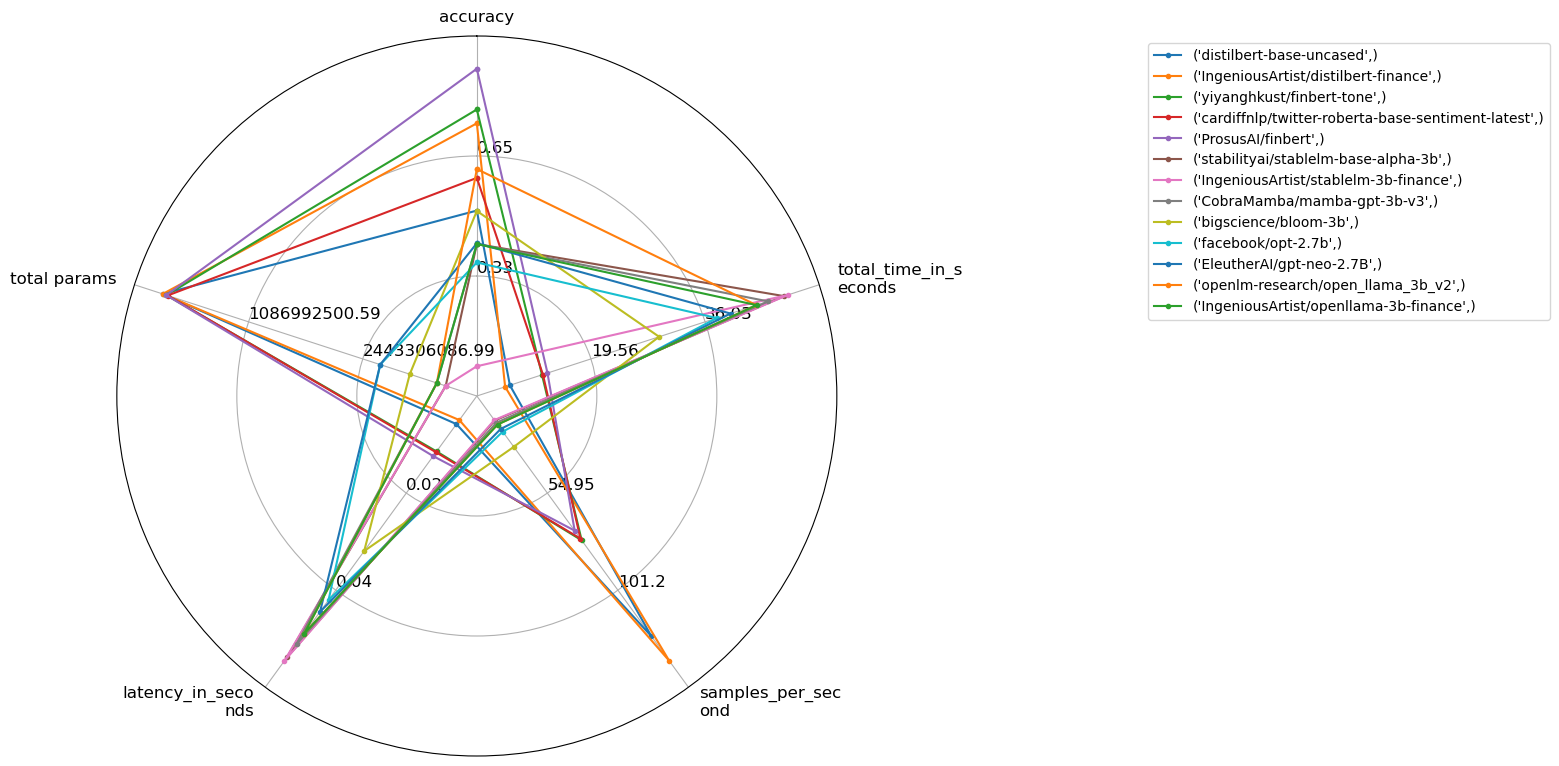

In [88]:
# Visualize Results

plot = radar_plot(data=data, model_names=models, invert_range=["total params"])
plot.set_figwidth(8)
plot.set_figheight(8)
plot.show()